In [1]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import pandas as pd

from utility import get_all_files_paths
from encoder import Encoder, load_encoder
from decoder import Decoder, load_decoder
from train import train_epoch, test_epoch

In [10]:
dataset_path="data/spec/GTZAN_646"
model_save_path="models/Echoes"
csv_save_path="output/Echoes_output"
encoded_space_dim=128

os.makedirs(model_save_path, exist_ok=True)
os.makedirs(csv_save_path, exist_ok=True)

In [3]:
class AudioDataset(Dataset):
    def __init__(self, file_paths):
        self.file_paths = file_paths

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        data = np.load(file_path)
        data = data[np.newaxis, :, :]  # Add a channel dimension
        data = torch.tensor(data, dtype=torch.float32)
        
        # Extract label from file name
        filename = os.path.basename(file_path)
        label_str = filename.split('.')[0]
        label = self.label_to_index(label_str)
        
        return data, label

    @staticmethod
    def label_to_index(label_str):
        label_map = {'blues': 'blues', 'disco': 'disco', 'rock': 'rock', 'metal': 'metal', 'classical': 'classical', 'pop': 'pop', 'reggae':'reggae','country':'country', 'hiphop':'hiphop', 'jazz':'jazz'}  # Extend this as needed
        return label_map.get(label_str, -1)  # Return -1 if label is not found

genres = ['blues', 'disco', 'rock', 'metal', 'pop', 'classical', 'reggae', 'country','hiphop','jazz']

genre_file_paths = {genre: get_all_files_paths(f"{dataset_path}/{genre}", [".npy"]) for genre in genres}

train_file_paths = []
valid_file_paths = []
test_file_paths = []

for genre, paths in genre_file_paths.items():
    m = len(paths)
    test_size = int(m * 0.3)
    valid_size = int((m - test_size) * 0.1)
    train_size = m - test_size - valid_size
    
    paths = np.array(paths)
    np.random.shuffle(paths)
    
    train_paths = paths[:train_size]
    valid_paths = paths[train_size:train_size + valid_size]
    test_paths = paths[train_size + valid_size:]
    
    train_file_paths.extend(train_paths)
    valid_file_paths.extend(valid_paths)
    test_file_paths.extend(test_paths)

train_dataset = AudioDataset(train_file_paths)
valid_dataset = AudioDataset(valid_file_paths)
test_dataset = AudioDataset(test_file_paths)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f'Training set size: {len(train_dataset)}')
print(f'Validation set size: {len(valid_dataset)}')
print(f'Test set size: {len(test_dataset)}')

Training set size: 630
Validation set size: 70
Test set size: 300


In [4]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder)
lr= 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=encoded_space_dim)
decoder = Decoder(encoded_space_dim=encoded_space_dim)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

device: cuda


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=167936, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Dropout(p=0.3, inplace=False)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(256, 16, 41))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 0))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output

In [5]:
num_epochs = 150
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
	train_loss =train_epoch(encoder,decoder,device,train_loader,loss_fn,optim)
	val_loss = test_epoch(encoder,decoder,device,test_loader,loss_fn)
	print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
	diz_loss['train_loss'].append(train_loss)
	diz_loss['val_loss'].append(val_loss)

	if (epoch+1)%10 ==0: 
		torch.save(encoder.state_dict(), f'{model_save_path}/encoder_{epoch+1}.pth')
		torch.save(decoder.state_dict(), f'{model_save_path}/decoder_{epoch+1}.pth')

	# plot_ae_outputs(encoder,decoder,n=10)


 EPOCH 1/100 	 train loss 0.3278737962245941 	 val loss 0.055272288620471954

 EPOCH 2/100 	 train loss 0.03275899961590767 	 val loss 0.02228286676108837

 EPOCH 3/100 	 train loss 0.021709002554416656 	 val loss 0.02104344591498375

 EPOCH 4/100 	 train loss 0.020640747621655464 	 val loss 0.022464238107204437

 EPOCH 5/100 	 train loss 0.019857387989759445 	 val loss 0.020707042887806892

 EPOCH 6/100 	 train loss 0.019460592418909073 	 val loss 0.022286202758550644

 EPOCH 7/100 	 train loss 0.019183581694960594 	 val loss 0.020330272614955902

 EPOCH 8/100 	 train loss 0.018051382154226303 	 val loss 0.016881084069609642

 EPOCH 9/100 	 train loss 0.017978115007281303 	 val loss 0.017886189743876457

 EPOCH 10/100 	 train loss 0.017389513552188873 	 val loss 0.017622247338294983

 EPOCH 11/100 	 train loss 0.017334681004285812 	 val loss 0.016360972076654434

 EPOCH 12/100 	 train loss 0.017145121470093727 	 val loss 0.016429821029305458

 EPOCH 13/100 	 train loss 0.016889717429

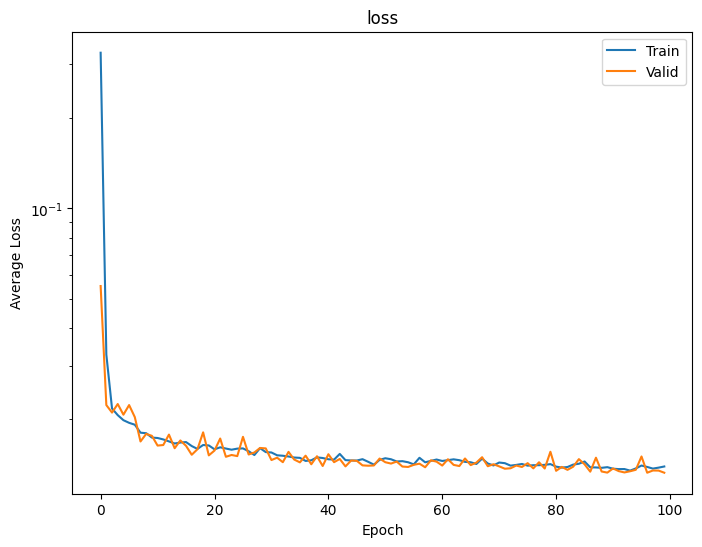

In [9]:
import matplotlib.pyplot as plt
# Plot losses
plt.figure(figsize=(8,6))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
# plt.grid()
plt.legend()
plt.title('loss')
plt.show()

In [7]:
encoder_path=f"{model_save_path}/encoder.pth"
decoder_path=f"{model_save_path}/decoder.pth"
torch.save(encoder.state_dict(), encoder_path)
torch.save(decoder.state_dict(), decoder_path)

encoder=load_encoder(encoder_path, encoded_space_dim)
# decoder=load_decoder(decoder_path, 64)
encoder.to(device)

/home/chuangyan/Data-Side-of-the-Moon/code/encoder.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=torch.devic

Encoder(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_lin): Sequential(
    (0): 

In [11]:
from tqdm import tqdm
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples.to_csv(f"{csv_save_path}/gtzan_encoded.csv", index=False)
encoded_samples

100%|██████████| 300/300 [00:00<00:00, 606.23it/s]


,Enc. Variable 0,Enc. Variable 1,Enc. Variable 2,Enc. Variable 3,Enc. Variable 4,Enc. Variable 5,Enc. Variable 6,Enc. Variable 7,Enc. Variable 8,Enc. Variable 9,...,Enc. Variable 119,Enc. Variable 120,Enc. Variable 121,Enc. Variable 122,Enc. Variable 123,Enc. Variable 124,Enc. Variable 125,Enc. Variable 126,Enc. Variable 127,label
0,-0.033718,1.817477,4.144113,-4.232020,-4.326110,-3.002643,7.961904,-2.948697,0.522704,0.628508,...,-15.002217,-4.142057,1.521534,3.712223,-4.215067,-3.866462,-3.075992,-2.857265,-1.478626,blues
1,1.301464,0.822950,5.451692,1.444834,-16.688171,-5.194202,2.484617,-3.314740,0.689527,-4.209526,...,-12.774661,1.938159,0.534633,2.146020,-13.867737,-3.712007,2.618486,-2.428350,-1.525728,blues
2,1.515743,0.045748,3.318819,0.575630,-12.363563,-4.167228,2.684551,-6.249999,1.687180,-4.464877,...,-10.338696,1.620797,2.312624,3.188072,-12.466332,-3.373974,1.125445,-2.147617,-0.790865,blues
3,1.113690,2.150320,3.233184,-3.409829,-9.596681,-4.271555,7.871771,-4.974378,-0.670203,-0.917834,...,-12.226016,1.498099,0.360116,7.728311,-2.371624,-7.492949,-2.023846,0.983112,-5.962563,blues
4,-1.534454,3.655893,9.262284,-3.300417,-13.671162,-3.883698,1.883350,2.556827,-1.524455,-0.365934,...,-17.776426,-4.910672,-3.121449,-1.660947,-13.423080,0.045372,3.161937,-2.281258,-2.884676,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,-0.340042,1.919894,5.843093,-7.410482,-3.252057,-0.395527,4.059687,-2.814261,-1.122914,-0.669604,...,-17.611132,-9.501643,1.595287,1.780288,-6.824885,0.771378,-3.506530,-1.558402,0.509128,jazz
296,-1.418358,8.346079,9.519427,-6.847875,-15.539566,1.921891,-0.223470,-1.759466,-1.200875,-1.737555,...,-19.505402,-14.803628,1.149176,-0.744134,-9.339139,4.055190,-1.470377,-0.145716,-0.986398,jazz
297,-0.764732,-0.917846,5.799482,-4.103572,-2.492486,-6.152018,7.851834,4.259847,-0.881147,2.121117,...,-19.497343,-1.205077,-3.468016,0.467359,-5.859750,-4.971124,-1.349071,-1.951826,-2.657120,jazz
298,-0.997705,2.472901,0.730518,-7.809084,9.143658,1.304039,-2.168705,0.597129,5.403446,0.509985,...,-10.062894,-7.201833,1.035084,-3.454558,0.809683,0.076646,0.200168,0.955423,3.749330,jazz
